In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.optim.optimizer import Optimizer

In [3]:
class SGD(Optimizer):
    """SGD
    """

    def __init__(
        self,
        params,
        lr = 1e-3
    ):
        
        defaults = dict(
            lr=lr
        )
        super(SGD, self).__init__(params, defaults)

    def step(self):
        """Performs a single optimization step.
        """
        with torch.no_grad():
            for group in self.param_groups:
                lr = group["lr"]
                
                for p in group['params']:
                    # the grad attribute is set by the backwards pass... here we just need to use it's value
                    p -= p.grad * lr


In [4]:
import torch

class Adam(Optimizer):
    """Adam optimizer
    """

    def __init__(
        self,
        params,
        lr= 1e-3,
        betas = (0.9, 0.999),
        eps = 1e-8
    ):

        defaults = dict(
            lr=lr,
            betas=betas,
            eps=eps,)
        super(Adam, self).__init__(params, defaults)
        # initialize hyper parameters for every parameter

    def __setstate__(self, state):
        super(Adam, self).__setstate__(state)

    def step(self):
        r"""Performs a single optimization step.
        """

        for group in self.param_groups:
            lr = group['lr']
            beta1, beta2 = group['betas']
            eps = group['eps']

            for p in group['params']:
                #TODO store the optimizer state (step, exp_avg, exp_avg_sq) in self.state[p] (create before first step)
                if self.state.get(p) is None:
                    step = 0
                    m = torch.Tensor([0])
                    v = torch.Tensor([0])
                    self.state[p] = (step, m, v)
                
                l_step, l_m, l_v = self.state[p]
                # update optimizer state
                step = l_step + 1
                m = beta1 * l_m + (1 - beta1) * p.grad
                v = beta2 * l_v  + (1 - beta2) * (p.grad ** 2)
                
                # calculate debiased exp_av and exp_avg_sq
                m_hat = m / (1 - (beta1 ** step))
                v_hat = v / (1 - (beta2 ** step))
                
                # perform the actual update
                with torch.no_grad():
                    p -= lr * (m_hat / ((torch.sqrt(v_hat) + eps)))
                # Update state
                self.state[p] = (step, m, v)


In [5]:
# Define Rosenbrock function
def rosenbrock(x: torch.Tensor , a=1, b=100) -> torch.Tensor:
    return (a-x[0])**2+b*(x[1]-x[0]**2)**2

In [6]:
import copy 

def test_optim(x: torch.Tensor, optim: torch.optim.Optimizer, steps: int = 10, debug: bool = True) -> None:
    rosen_values = []
    for i in range(steps):
        rosen_values.append(copy.deepcopy(x.detach().numpy()))
        optim.zero_grad()
        val = rosenbrock(x)
        val.backward()
        optim.step()
        if debug: 
            print(f"Iteration: {i} Current Value: {val:.3f}, current position: {x.data}")

    rosen_values.append(x.detach().numpy())
    return np.array(rosen_values)

In [7]:
# Test SGD
lr = 1e-3

start = torch.Tensor([-2, 2])
start.requires_grad = True
sgd = SGD([start], lr=lr)
sgd_values = test_optim(start, sgd)

print("torch optim : --------------------")
start = torch.Tensor([-2, 2])
start.requires_grad = True
torchSGD = torch.optim.SGD([start], lr=lr)
test_optim(start, torchSGD)

print()

Iteration: 0 Current Value: 409.000, current position: tensor([-0.3940,  2.4000])
Iteration: 1 Current Value: 505.840, current position: tensor([-0.7450,  1.9510])
Iteration: 2 Current Value: 197.938, current position: tensor([-1.1575,  1.6718])
Iteration: 3 Current Value: 15.678, current position: tensor([-1.3069,  1.6054])
Iteration: 4 Current Value: 6.374, current position: tensor([-1.2487,  1.6260])
Iteration: 5 Current Value: 5.502, current position: tensor([-1.2775,  1.6126])
Iteration: 6 Current Value: 5.225, current position: tensor([-1.2630,  1.6165])
Iteration: 7 Current Value: 5.167, current position: tensor([-1.2692,  1.6122])
Iteration: 8 Current Value: 5.150, current position: tensor([-1.2653,  1.6120])
Iteration: 9 Current Value: 5.144, current position: tensor([-1.2663,  1.6098])
torch optim : --------------------
Iteration: 0 Current Value: 409.000, current position: tensor([-0.3940,  2.4000])
Iteration: 1 Current Value: 505.840, current position: tensor([-0.7450,  1.9

/home/paul/workspaces/PycharmProjects/practical_pytorch_dl/venv/lib/python3.10/site-packages/torch/autograd/__init__.py:197: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


In [8]:
# Test Adam
lr = 1e-3

start = torch.Tensor([-2, 2])
start.requires_grad = True
torch_adam = Adam([start], lr=lr)
adam_values = test_optim(start, torch_adam, steps=10)

print("torch optim : --------------------")
start = torch.Tensor([-2, 2])
start.requires_grad = True
torch_adam = torch.optim.Adam([start], lr=lr)
test_optim(start, torch_adam)

print()

Iteration: 0 Current Value: 409.000, current position: tensor([-1.9990,  2.0010])
Iteration: 1 Current Value: 406.997, current position: tensor([-1.9980,  2.0020])
Iteration: 2 Current Value: 405.000, current position: tensor([-1.9970,  2.0030])
Iteration: 3 Current Value: 403.009, current position: tensor([-1.9960,  2.0040])
Iteration: 4 Current Value: 401.024, current position: tensor([-1.9950,  2.0050])
Iteration: 5 Current Value: 399.045, current position: tensor([-1.9940,  2.0060])
Iteration: 6 Current Value: 397.072, current position: tensor([-1.9930,  2.0070])
Iteration: 7 Current Value: 395.106, current position: tensor([-1.9920,  2.0080])
Iteration: 8 Current Value: 393.147, current position: tensor([-1.9910,  2.0090])
Iteration: 9 Current Value: 391.194, current position: tensor([-1.9900,  2.0100])
torch optim : --------------------
Iteration: 0 Current Value: 409.000, current position: tensor([-1.9990,  2.0010])
Iteration: 1 Current Value: 406.997, current position: tensor([

In [9]:
# Plot this shit
import numpy as np
import matplotlib.pyplot as plt

def plot(optim_values, title): 
# Get baseline for the contour plot
    X = np.arange(-2, 2, 0.15)
    Y = np.arange(-1, 3, 0.15)
    X, Y = np.meshgrid(X, Y)
    Z = rosenbrock(X,Y)

    # Initialize figure 
    plt.figure(figsize=(12, 7))
    plt.contour(X,Y,Z,200)

    for i, start in enumerate(optim_values[:-1]):
        end = optim_values[i + 1]

        plt.scatter(start[0], start[1], color ='r', zorder=20)
        plt.arrow(start[0], start[1], end[0] - start[0], end[1] - start[1], length_includes_head=True, head_width=0.03, zorder=20)

    # plot 
    plt.title(title)
    plt.show()


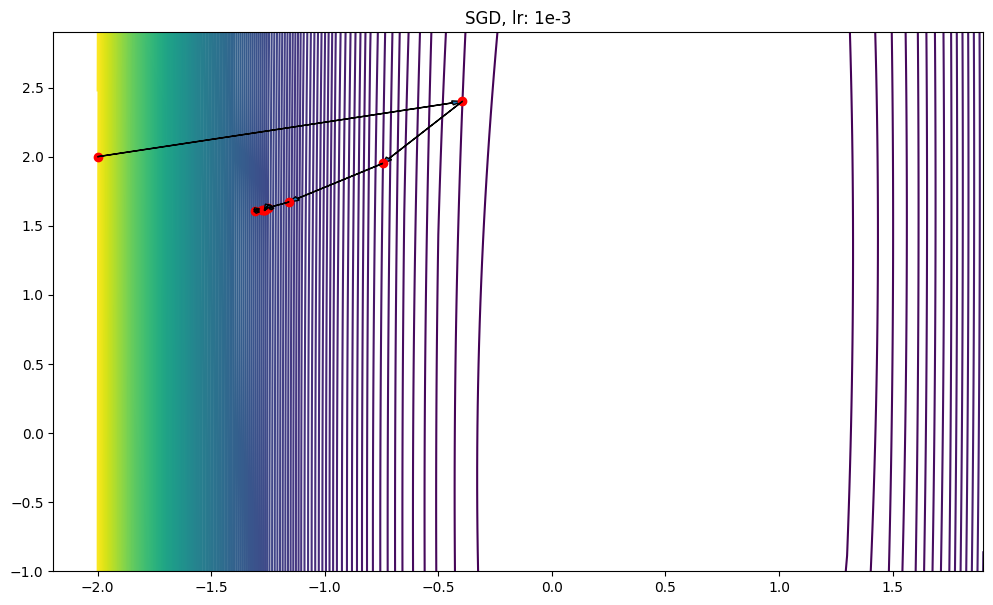

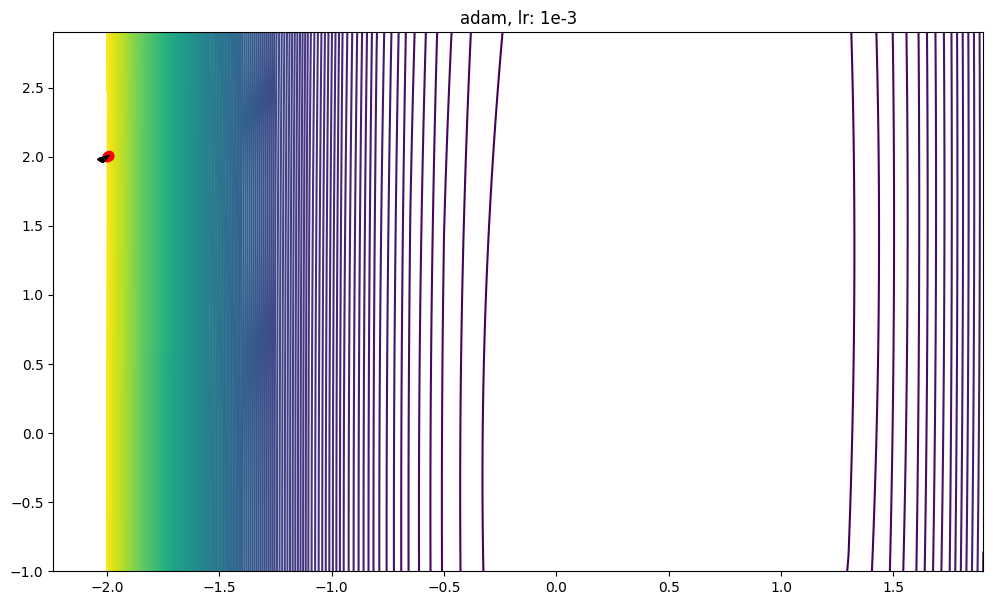

In [10]:
plot(sgd_values, "SGD, lr: 1e-3")
plot(adam_values, "adam, lr: 1e-3")


In [11]:
lr = 1e-3
steps = 10

start = torch.Tensor([-2, 2])
start.requires_grad = True
adam = Adam([start], lr=0.05)
adam_values = test_optim(start, adam, steps=steps, debug=False)

start = torch.Tensor([-2, 2])
start.requires_grad = True
sgd = SGD([start], lr=lr)
sgd_values = test_optim(start, sgd, steps=steps, debug=False)

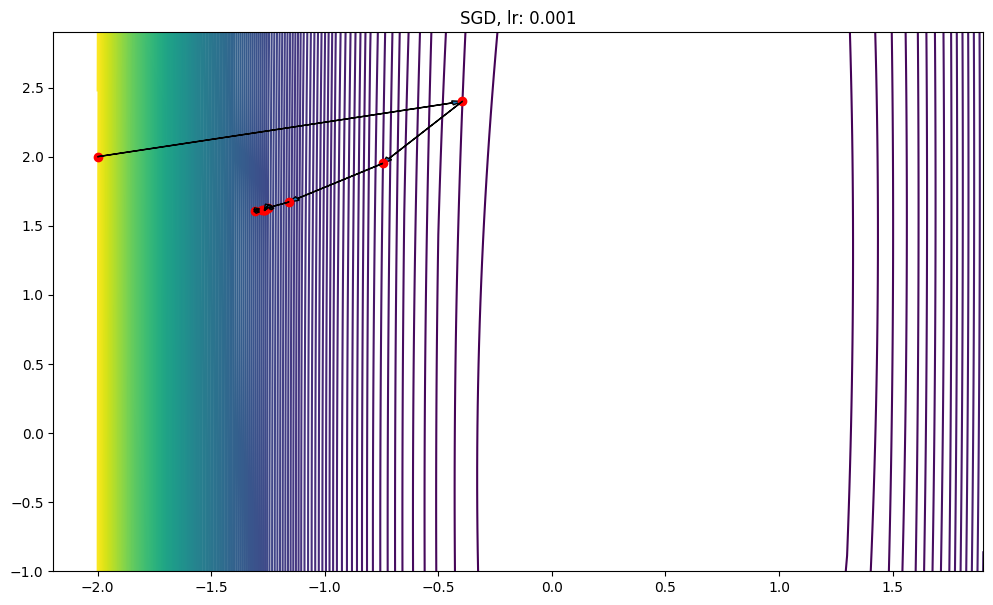

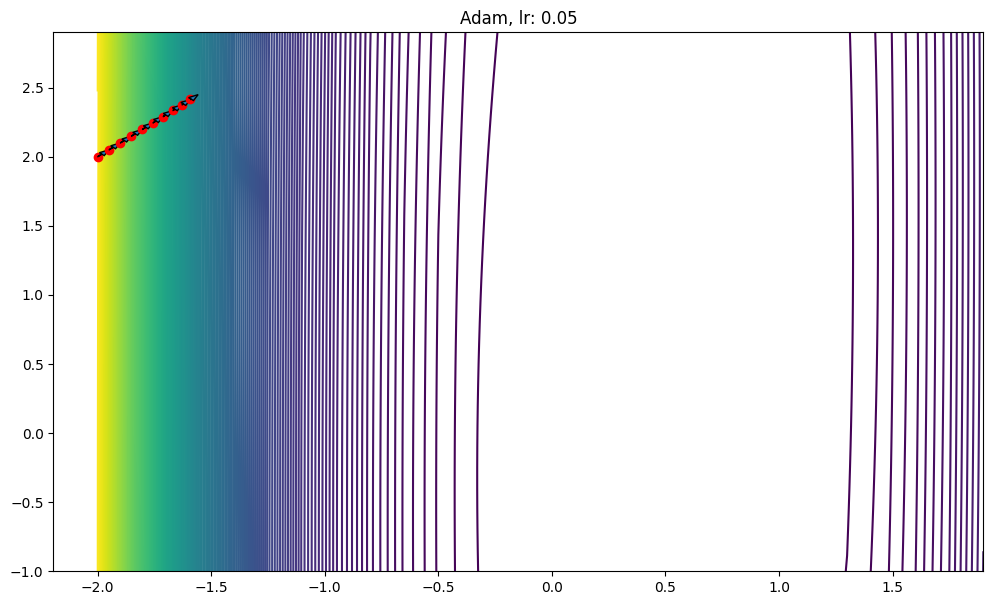

In [12]:
plot(sgd_values, f"SGD, lr: {lr}")
plot(adam_values, f"Adam, lr: 0.05")

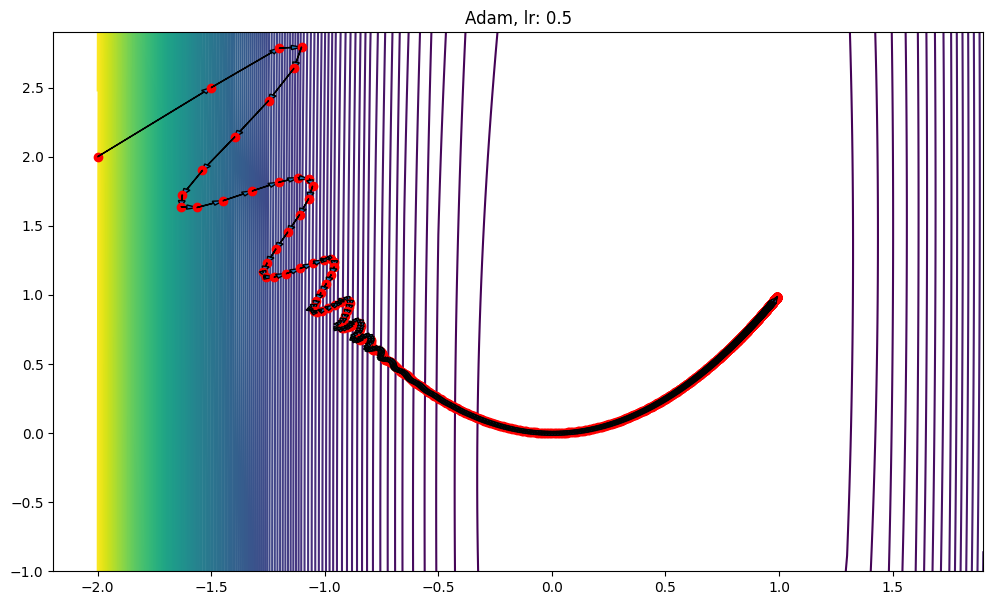

In [13]:
lr = 0.5
steps = 1000
start = torch.Tensor([-2, 2])
start.requires_grad = True
adam = Adam([start], lr=lr)
adam_values = test_optim(start, adam, steps=steps, debug=False)
plot(adam_values, f"Adam, lr: {lr}")

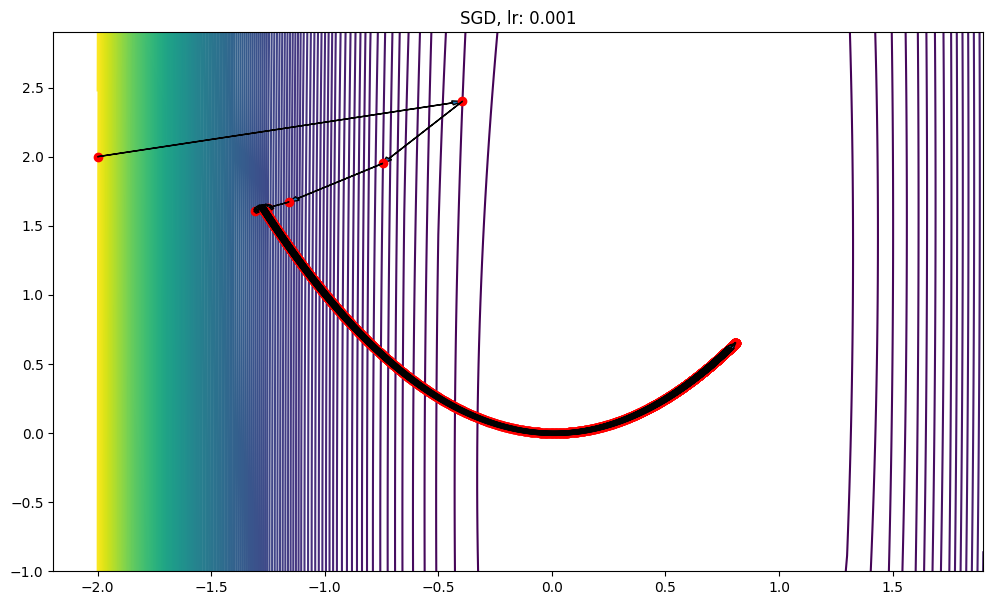

In [15]:
lr = 1e-3
steps = 3000
start = torch.Tensor([-2, 2])
start.requires_grad = True
sgd = SGD([start], lr=lr)
sgd_values = test_optim(start, sgd, steps=steps, debug=False)
plot(sgd_values, f"SGD, lr: {lr}")

# Findings C

## SGD:
- SGD can not handle large learning rates. -> goes to infinity
- SGD needs a low learning rate to converge to the minimum
- SGDs performance with an adequate lr is worse than adam eg needs ~3000 vs 1000 steps to converge

## Adam
- Adam needs a relatively high ~0.5 learning rate to converge efficiently to the optimum
- Adam does not converge to the optimum if the learning rate is to low